Predicting USD
=====

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('data/USD_INR2.csv')
df['Date'] = pd.to_datetime(df['Date'])
df_idx = df.set_index(['Date'], drop=True)
df_idx.head()

,Price,Open,High,Low,Change %
Date,,,,,
2017-08-10,64.165,63.898,64.175,63.855,0.48
2017-08-09,63.860,63.780,63.860,63.710,0.26
2017-08-08,63.692,63.750,63.785,63.615,-0.23
2017-08-07,63.840,63.710,63.865,63.648,0.26
2017-08-04,63.675,63.670,63.786,63.572,-0.05


In [21]:
# sort dates by index
df_idx = df_idx.sort_index(axis=1, ascending=True)
df_idx = df_idx.iloc[::-1]

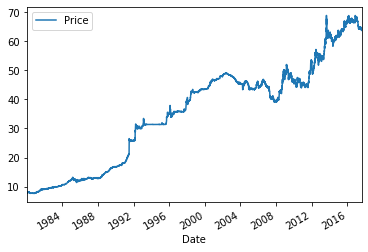

In [22]:
data = df_idx[['Price']]
data.plot(y='Price')

In [23]:
# 시간의 범위 파악하기
diff = data.index.values[-1] - data.index.values[0]

# 시간의 범위를 일수로 반환
days = diff.astype('timedelta64[D]')
days = days / np.timedelta64(1, 'D')

# 시간의 범위를 연수로 반환
years = int(days/365)
print('Total data : %d years'%years)
print('80 percent data = 1980 to %d'%(1980 + int(0.8 * years)))

Total data : 37 years
80 percent data = 1980 to 2009


Create training and testing data
-----------

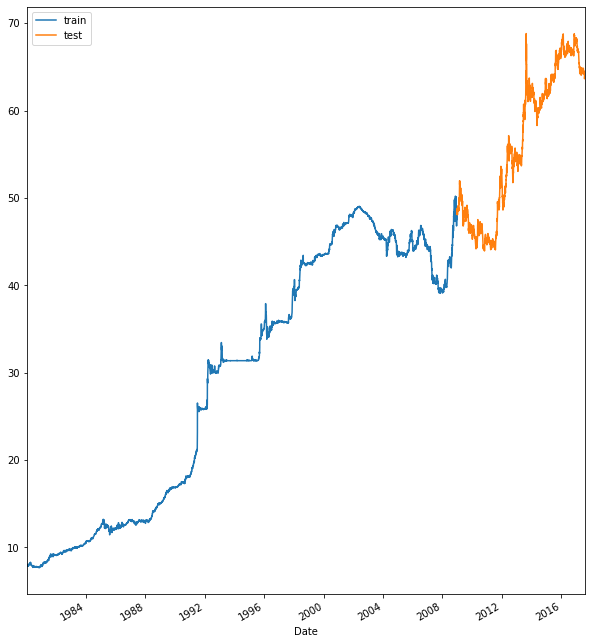

In [24]:
split_date = pd.Timestamp('01-01-2009')

train = data.loc[:split_date]
test = data.loc[split_date:]

ax = train.plot(figsize=(10,12))
test.plot(ax=ax)
plt.legend(['train', 'test'])
plt.show()

Normalize the dataset
------

In [25]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [26]:
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

# column으로 2 shift한만큼
# X_train --> X_1
# y_train --> Y
X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

X_train = X_train.as_matrix()
y_train = y_train.as_matrix()

X_test = X_test.as_matrix()
y_test = y_test.as_matrix()

In [27]:
print('Train size: (%d x %d)'%(X_train.shape[0], X_train.shape[1]))
print('Test size: (%d x %d)'%(X_test.shape[0], X_test.shape[1]))

Train size: (7451 x 1)
Test size: (2245 x 1)


Trial1 : SVM Regressor
----------

In [31]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')

In [37]:
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

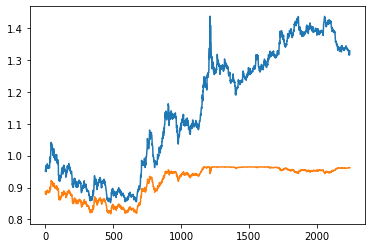

In [38]:
plt.plot(y_test)

plt.plot(y_pred)

In [40]:
# evaluation
from sklearn.metrics import r2_score

def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

r2_test = r2_score(y_test, y_pred)
print("R-squared is: %f"%r2_test)

R-squared is: -0.963381


Trial2 : Simple Neural Network
-----------

In [41]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras.backend as K

In [45]:
K.clear_session()
model = Sequential()
model.add(Dense(1, input_shape=(X_test.shape[1],), activation='tanh', kernel_initializer='lecun_uniform'))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs = 20, verbose=0)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


R-Squared: -1.163215


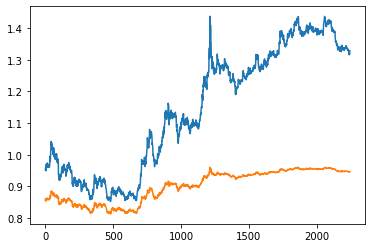

In [43]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)
print('R-Squared: %f'%(r2_score(y_test, y_pred)))

Trial3 : More complex Neural Network
    ---

In [47]:
from keras.layers import LSTM

K.clear_session()
model = Sequential()
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=0)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                100       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 2,701
Trainable params: 2,701
Non-trainable params: 0
_________________________________________________________________


R-Squared: 0.996779


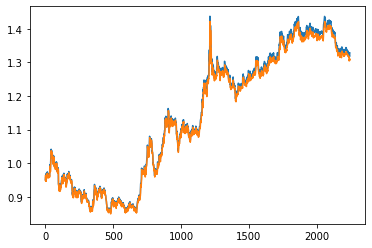

In [48]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)
print('R-Squared: %f'%(r2_score(y_test, y_pred)))